# Gradient Boosted Tree Classification

Gradient Boosted Tree (GBT) is a popular machine learning algorithm used for classification problems. It is an ensemble method that combines multiple weak learners, in this case, decision trees, to create a stronger model that is capable of handling complex non-linear relationships between features and the target variable.

In this Jupyter notebook, we will explore how to use GBT for classification problems using PySpark. Specifically, we will use the Wine dataset, which contains information about different types of wine, to build a GBT model that can predict the type of wine based on its physical and chemical characteristics. We will cover the following topics:

- Loading and preparing the data
- Training a GBT model using PySpark's MLlib library
- Evaluating the model's performance using various metrics
- Tuning the model's hyperparameters to improve its performance

By the end of this notebook, you should have a good understanding of how GBT works and how to apply it to real-world classification problems using PySpark.

## Introduction

The Wine dataset is a classic machine learning dataset that contains the results of a chemical analysis of wines grown in a specific area of Italy. The dataset consists of 178 samples, each representing a different wine. The chemical analysis determined the quantities of 13 constituents found in each of the three types of wines: "Class 0" (59 samples), "Class 1" (71 samples), and "Class 2" (48 samples). The attributes of the wine include things like alcohol content, malic acid, ash, and color intensity. This dataset is commonly used for classification problems and has been extensively studied in the machine learning literature.

### Importing necessery libraries and download the dataset

In this section, we will import the required libraries and download the Wine dataset.

#### Importing Libraries
We will begin by importing the necessary libraries required for our analysis. These include:

- SparkSession: used for start and mantain a spark session
- RFormula: used for transform the dataset in something meaninful to spark
- StandardScaler: used for scaler the dataset
- GBT: used for construct the model
- Pipeline: used for create a pipeline
- skelearn: only used here to easy create a confusion matrix
- ParamGridBuilder: used for tuning the hyperparams of the model
- TrainValidationSplit: used for crossvalidation and select best hyperparams
- matplotlib: used for data visualization

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn import metrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql.functions import when

#### Downloading the Heart Disease dataset
Next, we will download the Wine dataset using the curl command. The dataset is available in a CSV format.

Each column represents the following information:

1. alcohol: the percentage of alcohol content in the wine
2. malic_acid: the amount of malic acid in the wine
3. ash: the amount of ash in the wine
4. alcalinity_of_ash: the level of alkalinity of ash in the wine
5. magnesium: the amount of magnesium in the wine
6. total_phenols: the total amount of phenols in the wine
7. flavanoids: the amount of flavonoids in the wine
8. nonflavanoid_phenols: the total amount of non-flavonoid phenols in the wine
9. proanthocyanins: the amount of proanthocyanins in the wine
10. color_intensity: the intensity of color in the wine
11. hue: the hue of the wine
12. od280/od315_of_diluted_wines: the OD280/OD315 ratio of the diluted wines
13. proline: the amount of proline in the wine

The target variable is the class column, which represents the class of the wine. There are three classes of wine in this dataset:

- class_0: Wine produced in the region of Barolo in Italy
- class_1: Wine produced in the region of Grignolino d'Asti in Italy
- class_2: Wine produced in the region of Barbera in Italy

In [2]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data -o wine.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10782  100 10782    0     0   7634      0  0:00:01  0:00:01 --:--:--  7635


In [3]:
schema = 'class INT, alcohol FLOAT, malic_acid FLOAT, ash FLOAT, alcalinity FLOAT, magnesium FLOAT, total_phenols FLOAT, flavanoids FLOAT, nonflavanoid_phenols FLOAT, proanthocyanins FLOAT, color_intensity FLOAT, hue FLOAT, od FLOAT, proline FLOAT'
# init SparkSession
spark = SparkSession.builder.appName('GBTClassifier').getOrCreate()
# read the csv using pyspark
wine = spark.read.csv('./wine.csv', schema=schema, header=False)

# print few lines of the dataframe
wine.show(5)

+-----+-------+----------+----+----------+---------+-------------+----------+--------------------+---------------+---------------+----+----+-------+
|class|alcohol|malic_acid| ash|alcalinity|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|  od|proline|
+-----+-------+----------+----+----------+---------+-------------+----------+--------------------+---------------+---------------+----+----+-------+
|    1|  14.23|      1.71|2.43|      15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|3.92| 1065.0|
|    1|   13.2|      1.78|2.14|      11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05| 3.4| 1050.0|
|    1|  13.16|      2.36|2.67|      18.6|    101.0|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03|3.17| 1185.0|
|    1|  14.37|      1.95| 2.5|      16.8|    113.0|         3.85|      3.49|                0.24|        

## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [4]:
from pyspark.sql.functions import round
temp = wine.drop('class')
temp.describe().select(['summary'] + [round(c, 2).alias(c) for c in temp.columns]).show()

+-------+-------+----------+-----+----------+---------+-------------+----------+--------------------+---------------+---------------+-----+-----+-------+
|summary|alcohol|malic_acid|  ash|alcalinity|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity|  hue|   od|proline|
+-------+-------+----------+-----+----------+---------+-------------+----------+--------------------+---------------+---------------+-----+-----+-------+
|  count|  178.0|     178.0|178.0|     178.0|    178.0|        178.0|     178.0|               178.0|          178.0|          178.0|178.0|178.0|  178.0|
|   mean|   13.0|      2.34| 2.37|     19.49|    99.74|          2.3|      2.03|                0.36|           1.59|           5.06| 0.96| 2.61| 746.89|
| stddev|   0.81|      1.12| 0.27|      3.34|    14.28|         0.63|       1.0|                0.12|           0.57|           2.32| 0.23| 0.71| 314.91|
|    min|  11.03|      0.74| 1.36|      10.6|     70.0|         0.98|      0

In [5]:
wine.select('class').distinct().show()

+-----+
|class|
+-----+
|    1|
|    3|
|    2|
+-----+



In order to run GBT on the dataset, we will need to reduce it to only two classes, as currently it only supports binary classification.

In [6]:
from pyspark.sql.functions import col
wine_reduced = wine.filter(col('class') != 3)

In [7]:
wine_reduced = wine_reduced.withColumn("class_binary", when(wine_reduced["class"] != 1, 1).otherwise(0))

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [8]:
train, test = wine_reduced.randomSplit([0.8, 0.2])

In [9]:
formula = RFormula(formula='class_binary ~ . - class', featuresCol='features', labelCol='label', handleInvalid = "skip")
# only to see if everything is ok
formula.fit(train).transform(train).select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[12.8500003814697...|  0.0|
|[13.0500001907348...|  0.0|
|[13.0500001907348...|  0.0|
|[13.0500001907348...|  0.0|
|[13.0500001907348...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [10]:
# IMPORTANT only fit the scaler using the training set
temp = formula.fit(train).transform(train)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', )
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[12.8500003814697...|[14.4176777477909...|
|[13.0500001907348...|[14.6420771807872...|
|[13.0500001907348...|[14.6420771807872...|
|[13.0500001907348...|[14.6420771807872...|
|[13.0500001907348...|[14.6420771807872...|
+--------------------+--------------------+
only showing top 5 rows



## Model Training
 Here we will build the model and create the pipeline that will be trained
 
### Building a GBT Classifier

In [11]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [12]:
pipeline = Pipeline(stages=[formula, scaler, gbt])

### Training the model on training set

In [13]:
model = pipeline.fit(train)

### Evaluating the performance of the model

In [14]:
prd = model.transform(test)

evaluator = BinaryClassificationEvaluator()

# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9877717391304348
Area under ROC = 0.9565217391304348


## Model Tuning and Interpretation

Fine-tuning the model (e.g., hyperparameter tuning)

In [68]:
gbt_param_builder = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 5, 10])
    .addGrid(gbt.maxBins, [10, 20, 30, 40, 50])
    .addGrid(gbt.stepSize, [0.01, 0.1, 1.0])
    .addGrid(gbt.maxIter, [5, 10, 50])
    .addGrid(gbt.featureSubsetStrategy,['auto', 'all', 'onethird', 'sqrt', 'log2'])
    .build())
pipeline = Pipeline(stages=[formula, scaler, gbt])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=gbt_param_builder, evaluator=evaluator, trainRatio=0.8)

In [69]:
model2 = tvs.fit(train)
prd2 = model2.transform(test)
prd2.select('prediction', 'label').show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [70]:
# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9349489795918368
Area under ROC = 0.9693877551020408


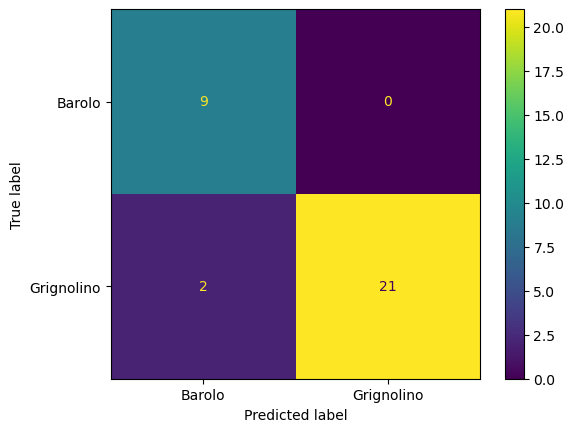

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Barolo','Grignolino'])
cm_display.plot()
plt.show()

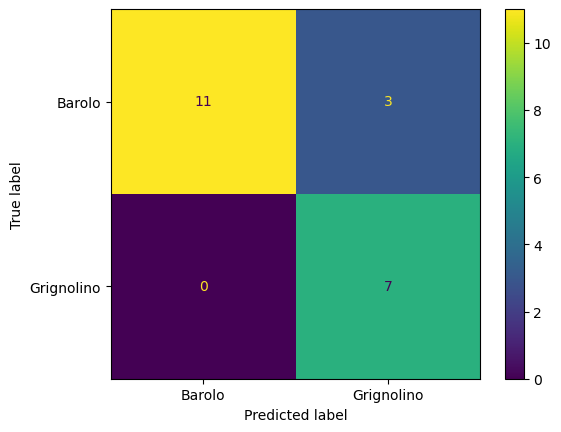

In [74]:
df_prd2 = prd2.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['label'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Barolo','Grignolino'])
cm_display.plot()
plt.show()

In [ ]:
spark.stop()